---
## Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

In [3]:


# Load train data
train_path = "/content/train.csv"
#train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# View shape and features
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Training data shape: (9543, 2)

Training data columns: ['text', 'label']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


---
## Set the seed for reproducibulity
---

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

---
## Text Cleaning
---
Roberta was trained on unprocessed data, therefore no text cleaning is necassary.

---
## Data split into train and validation
---

In [5]:
# Train and Test (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["label"],
    test_size=0.2, stratify=train_df["label"], random_state=42
)

---
## Prepare hugging face DatasetDict
---
This stores data splits in an accessible way for other hugging face tools

In [6]:
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()}),
    "test": Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
})

---
## Use roberta tokenizer
---

In [7]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=64)

tokenized = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

---
## Show an example of a tweet: original and tokenized
---

In [8]:
# Show one example from the training set
sample = tokenized["train"][0]

# Decode the input_ids back into readable text
decoded_text = tokenizer.decode(sample["input_ids"])

# Display nicely
print("Original Text:")
print(dataset["train"][0]["text"])
print("\nTokenized Input IDs:")
print(sample["input_ids"])
print("\nDecoded (Recovered) Text:")
print(decoded_text)
print("\nAttention Mask:")
print(sample["attention_mask"])
print("\nLabel:")
print(sample["label"])

Original Text:
Nasdaq prices 600M of 0.875% senior notes

Tokenized Input IDs:
[0, 487, 281, 5946, 850, 5594, 448, 9, 321, 4, 29271, 207, 949, 2775, 2]

Decoded (Recovered) Text:
<s>Nasdaq prices 600M of 0.875% senior notes</s>

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Label:
2


---
## Dynamic padding collator
---
Data collators are objects that will form a batch by using a list of dataset elements as input

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

---
## Compute metrics
---

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

---
## Training arguments
---

In [11]:
training_args = TrainingArguments(
    output_dir="./results/roberta_full",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs/roberta_full",
    report_to="none"
)

---
## Load model and trainer
---

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-2311602724>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


---
## Train the model
---

In [13]:
trainer.train()

Step,Training Loss
500,0.543100
1000,0.423900
1500,0.316700
2000,0.309800
2500,0.195900


TrainOutput(global_step=2865, training_loss=0.3409312889005917, metrics={'train_runtime': 130.6573, 'train_samples_per_second': 175.283, 'train_steps_per_second': 21.928, 'total_flos': 555225839679420.0, 'train_loss': 0.3409312889005917, 'epoch': 3.0})

---
## Evaluate on test
---

In [14]:
preds = trainer.predict(tokenized["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = np.array(tokenized["test"]["label"])

# Print classification report
report = classification_report(y_true, y_pred, digits=4)
print("Test Set Classification Report:\n")
print(report)

Test Set Classification Report:

              precision    recall  f1-score   support

           0     0.8013    0.8403    0.8203       288
           1     0.8285    0.8909    0.8586       385
           2     0.9388    0.9061    0.9222      1236

    accuracy                         0.8931      1909
   macro avg     0.8562    0.8791    0.8670      1909
weighted avg     0.8958    0.8931    0.8940      1909



---
## Confusion Matrix
---

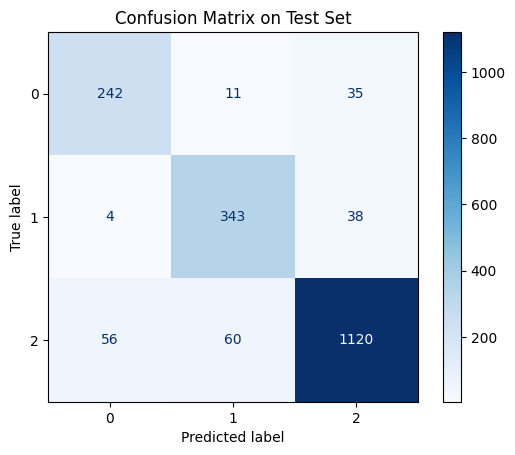

In [15]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-4209720944>:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training with train/val evaluation...



Evaluating on training set...
Evaluating on validation set...

Epoch 1 Results:
Train Accuracy: 0.9232 | Val Accuracy: 0.8895
Train F1: 0.8988 | Val F1: 0.8573
Accuracy Gap: 0.0338
Status: ✅ No overfitting


Evaluating on training set...
Evaluating on validation set...

Epoch 2 Results:
Train Accuracy: 0.9391 | Val Accuracy: 0.8690
Train F1: 0.9271 | Val F1: 0.8453
Accuracy Gap: 0.0700
Status: ⚠️  Mild overfitting


Evaluating on training set...
Evaluating on validation set...

Epoch 3 Results:
Train Accuracy: 0.9734 | Val Accuracy: 0.8973
Train F1: 0.9656 | Val F1: 0.8713
Accuracy Gap: 0.0761
Status: ⚠️  Mild overfitting



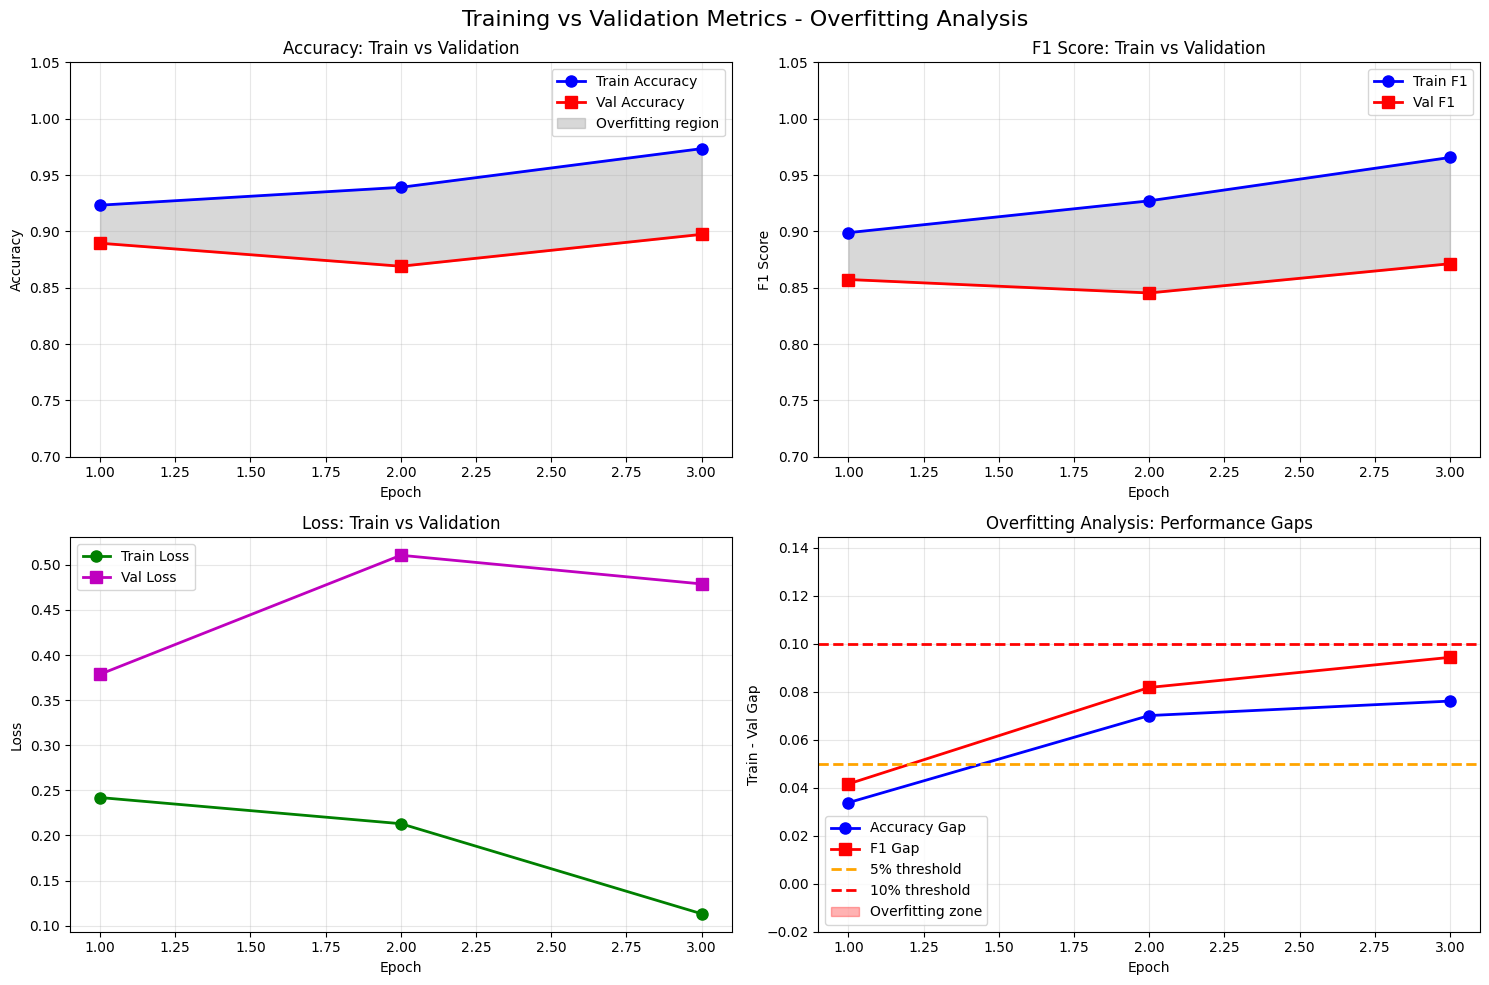


TRAINING SUMMARY

Epoch 1:
  Train: Acc=0.9232, F1=0.8988, Loss=0.2421
  Val:   Acc=0.8895, F1=0.8573, Loss=0.3788
  Gaps:  Acc=0.0338, F1=0.0416

Epoch 2:
  Train: Acc=0.9391, F1=0.9271, Loss=0.2131
  Val:   Acc=0.8690, F1=0.8453, Loss=0.5107
  Gaps:  Acc=0.0700, F1=0.0817

Epoch 3:
  Train: Acc=0.9734, F1=0.9656, Loss=0.1132
  Val:   Acc=0.8973, F1=0.8713, Loss=0.4789
  Gaps:  Acc=0.0761, F1=0.0943

🏆 Best Epoch: 3 (Val F1: 0.8713)


In [23]:
# Custom callback to evaluate on training set during training
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class EvalTrainCallback(TrainerCallback):
    """
    Callback that evaluates on both training and validation sets during training.
    Based on: https://discuss.huggingface.co/t/metrics-for-training-set-in-trainer/2461/4
    """
    def __init__(self, trainer, train_dataset, eval_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset

        # Storage for metrics
        self.train_metrics = []
        self.eval_metrics = []
        self.epochs = []

    def on_epoch_end(self, args, state, control, **kwargs):
        """Called at the end of each epoch"""
        # Evaluate on training set
        print("\nEvaluating on training set...")
        train_output = self.trainer.evaluate(eval_dataset=self.train_dataset)

        # Evaluate on validation set
        print("Evaluating on validation set...")
        eval_output = self.trainer.evaluate(eval_dataset=self.eval_dataset)

        # Store metrics
        self.train_metrics.append({
            'accuracy': train_output.get('eval_accuracy', 0),
            'f1': train_output.get('eval_f1', 0),
            'loss': train_output.get('eval_loss', 0)
        })

        self.eval_metrics.append({
            'accuracy': eval_output.get('eval_accuracy', 0),
            'f1': eval_output.get('eval_f1', 0),
            'loss': eval_output.get('eval_loss', 0)
        })

        self.epochs.append(state.epoch)

        # Print current epoch results
        print(f"\n{'='*60}")
        print(f"Epoch {state.epoch:.0f} Results:")
        print(f"Train Accuracy: {train_output.get('eval_accuracy', 0):.4f} | Val Accuracy: {eval_output.get('eval_accuracy', 0):.4f}")
        print(f"Train F1: {train_output.get('eval_f1', 0):.4f} | Val F1: {eval_output.get('eval_f1', 0):.4f}")
        print(f"Accuracy Gap: {train_output.get('eval_accuracy', 0) - eval_output.get('eval_accuracy', 0):.4f}")

        # Check for overfitting
        acc_gap = train_output.get('eval_accuracy', 0) - eval_output.get('eval_accuracy', 0)
        if acc_gap < 0.05:
            print("Status: ✅ No overfitting")
        elif acc_gap < 0.10:
            print("Status: ⚠️  Mild overfitting")
        else:
            print("Status: ❌ Significant overfitting")
        print(f"{'='*60}\n")

# Initialize model (assuming you already have this from your notebook)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Create trainer without the evaluation callback first
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Create and add the custom callback
eval_callback = EvalTrainCallback(
    trainer=trainer,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"]
)

# Add the callback to trainer
trainer.add_callback(eval_callback)

# Train the model
print("Starting training with train/val evaluation...")
trainer.train()

# Plotting function
def plot_training_curves(eval_callback):
    """Plot training and validation curves"""

    if not eval_callback.epochs:
        print("No evaluation data to plot!")
        return

    epochs = eval_callback.epochs
    train_acc = [m['accuracy'] for m in eval_callback.train_metrics]
    val_acc = [m['accuracy'] for m in eval_callback.eval_metrics]
    train_f1 = [m['f1'] for m in eval_callback.train_metrics]
    val_f1 = [m['f1'] for m in eval_callback.eval_metrics]
    train_loss = [m['loss'] for m in eval_callback.train_metrics]
    val_loss = [m['loss'] for m in eval_callback.eval_metrics]

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training vs Validation Metrics - Overfitting Analysis', fontsize=16)

    # Plot 1: Accuracy
    ax1 = axes[0, 0]
    ax1.plot(epochs, train_acc, 'b-o', label='Train Accuracy', linewidth=2, markersize=8)
    ax1.plot(epochs, val_acc, 'r-s', label='Val Accuracy', linewidth=2, markersize=8)
    ax1.fill_between(epochs, train_acc, val_acc, alpha=0.3, color='gray', label='Overfitting region')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy: Train vs Validation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.7, 1.05)

    # Plot 2: F1 Score
    ax2 = axes[0, 1]
    ax2.plot(epochs, train_f1, 'b-o', label='Train F1', linewidth=2, markersize=8)
    ax2.plot(epochs, val_f1, 'r-s', label='Val F1', linewidth=2, markersize=8)
    ax2.fill_between(epochs, train_f1, val_f1, alpha=0.3, color='gray')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score: Train vs Validation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.7, 1.05)

    # Plot 3: Loss
    ax3 = axes[1, 0]
    ax3.plot(epochs, train_loss, 'g-o', label='Train Loss', linewidth=2, markersize=8)
    ax3.plot(epochs, val_loss, 'm-s', label='Val Loss', linewidth=2, markersize=8)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss: Train vs Validation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Overfitting Metrics (Gaps)
    ax4 = axes[1, 1]
    acc_gap = [t - v for t, v in zip(train_acc, val_acc)]
    f1_gap = [t - v for t, v in zip(train_f1, val_f1)]

    ax4.plot(epochs, acc_gap, 'b-o', label='Accuracy Gap', linewidth=2, markersize=8)
    ax4.plot(epochs, f1_gap, 'r-s', label='F1 Gap', linewidth=2, markersize=8)
    ax4.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='5% threshold')
    ax4.axhline(y=0.1, color='red', linestyle='--', linewidth=2, label='10% threshold')
    ax4.fill_between(epochs, 0, acc_gap, where=[g > 0.1 for g in acc_gap],
                     color='red', alpha=0.3, label='Overfitting zone')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Train - Val Gap')
    ax4.set_title('Overfitting Analysis: Performance Gaps')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(-0.02, max(max(acc_gap), max(f1_gap)) + 0.05)

    plt.tight_layout()
    plt.show()

    # Print final summary
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)

    for i, epoch in enumerate(epochs):
        print(f"\nEpoch {epoch:.0f}:")
        print(f"  Train: Acc={train_acc[i]:.4f}, F1={train_f1[i]:.4f}, Loss={train_loss[i]:.4f}")
        print(f"  Val:   Acc={val_acc[i]:.4f}, F1={val_f1[i]:.4f}, Loss={val_loss[i]:.4f}")
        print(f"  Gaps:  Acc={acc_gap[i]:.4f}, F1={f1_gap[i]:.4f}")

    # Find best epoch
    best_val_f1_idx = val_f1.index(max(val_f1))
    print(f"\n🏆 Best Epoch: {epochs[best_val_f1_idx]:.0f} (Val F1: {max(val_f1):.4f})")

    # Early stopping recommendation
    if len(epochs) > 1:
        if val_acc[-1] < val_acc[-2] and val_f1[-1] < val_f1[-2]:
            print("\n⚠️  RECOMMENDATION: Validation performance decreased in the last epoch!")
            print(f"   Consider using only {epochs[best_val_f1_idx]:.0f} epochs for training.")
        elif acc_gap[-1] > 0.1:
            print("\n⚠️  RECOMMENDATION: Significant overfitting detected!")
            print(f"   Consider stopping at epoch {epochs[best_val_f1_idx]:.0f} or using regularization.")

    print("="*60)

# Plot the results
plot_training_curves(eval_callback)

# Optional: Get predictions using the best model
# The trainer already has load_best_model_at_end=True, so it should have the best model